In [2]:
!pip install pycocotools --user

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373761 sha256=5d9fa500d156cb59ea01a5c29b8c7b58963c3aa8d7d96dd0c0bec0e3e7d5f9d9
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
import time

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_labels, test_labels = tf.squeeze(tf.one_hot(train_labels, len(classes))), tf.squeeze(tf.one_hot(test_labels, len(classes)))
train_images, test_images = tf.convert_to_tensor(train_images), tf.convert_to_tensor(test_images)

170508288/170498071 [==============================] - 4s 0us/step


In [5]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomZoom((-0.1,0.1)),
    tf.keras.layers.Normalization()
])
augment.layers[-1].adapt(train_images)

2022-12-02 14:22:48.567276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Wczytałem Cifar10, następnie przygotowałem model, który wykonuje augmentację w postaci RandomFlip, RandomZoom oraz normalizację, ponieważ niestety tensorflow nie ma RandomResizedCrop a rozwiązania jakie znalazłem nie działały.  
W tensorflow, z tego co rozumiem to albo wrzuca się przez to dane, albo podpina na początek modelu i tak spróbuję(choć ostatnio miałem problem).  
Dodatkowo zaaplikowałem one hot encoding na labele i zrzutowałem obrazki na tensor.

In [6]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1,self.size,self.size,1],
            strides=[1,self.size,self.size,1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Klasa Patches zawiera implementację rozkładania obrazka na patche, wykorzystuję do tego tf.image.extract_patches.  
Warto zauważyć, że klasa dziedziczy z tf.keras.layers.Layer, dzięki czemu może być częścią modelu.

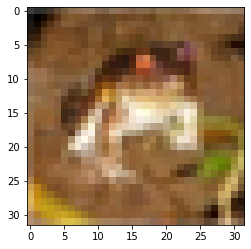

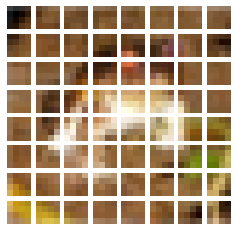

In [7]:
patches = Patches(4)
plt.imshow(train_images[0])
plt.show()
patched = patches(tf.expand_dims(train_images[0],0))

plt.figure(figsize=(4,4))
for ix, im in enumerate(patched[0]):
    plt.subplot(8, 8, ix + 1)
    im = tf.reshape(im, (4,4,3))
    plt.imshow(im)
    plt.axis('off')

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_patches=8*8, projection_dim=256):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        init = tf.random_normal_initializer()
        class_token = init(shape=(1,self.projection_dim), dtype=tf.float32)
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = tf.keras.layers.Dense(units=self.projection_dim)
        self.positional_embedding = tf.keras.layers.Embedding(input_dim=self.num_patches+1, output_dim=self.projection_dim)

    def call(self, batch):
        batch_size = tf.shape(batch)[0]
        class_token = tf.tile(input=self.class_token, multiples=[batch_size,1])
        class_token = tf.reshape(class_token, shape=(batch_size,1,self.projection_dim))
        embs = self.projection(batch)
        embs = tf.concat([class_token, embs], 1)
        positions = tf.range(0, self.num_patches+1, 1)
        pos_embs = self.positional_embedding(positions)
        encoded = embs+pos_embs
        return encoded

Do stworzenia encodera użyłem:
- tf.random_normal_initializer - do zainicjowania class tokena, inicjuję go trochę jako batch, dlatego wymiar (1,rozmiar tokena)
- tf.Variable - aby class token się uczył i był używany przez framework
- tf.keras.layers.Dense - do liniowego embeddingu patchy
- tf.keras.layers.Embedding - do embeddingu pozycyjnego


Ponadto do wykorzystania go używam:
- tf.tile - aby dodać class_token do każdego obrazka w batchu
- tf.reshape - aby batch class_tokenów miał właściwe wymiary
- warstwy dense, wcześniej zainicjowanej - do liniowego embeddingu patchy
- tf.concat - aby dokleić do batcha class_tokeny
- tf.range - aby wyznaczyć embeddingi pozycyjne
- warstwy embedding, wcześniej zainicjowanej - do wyznaczenia embeddingu pozycyjnego - ona się będzie uczyć, ale potrzebuje dostać tf.range
- sumuję embeddingi i otrzymuję encoding

In [9]:
class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_head=8, projection_dim=256, hidden_units=512):
        super().__init__()
        self.num_head = num_head
        self.projection_dim = projection_dim
        self.hidden_units = hidden_units
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.multihead = tf.keras.layers.MultiHeadAttention(num_heads=self.num_head, key_dim=self.projection_dim)
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.linear1 = tf.keras.layers.Dense(units=self.hidden_units, activation=tf.nn.gelu)
        self.dropout1 = tf.keras.layers.Dropout(rate=0.2)
        self.linear2 = tf.keras.layers.Dense(units=self.projection_dim)
        self.dropout2 = tf.keras.layers.Dropout(rate=0.2)

    def call(self, batch):
        batch1 = self.norm1(batch)
        attentioned = self.multihead(batch1, batch1)
        self.attention_output = attentioned
        batch2 = tf.keras.layers.Add()([attentioned, batch])
        batch3 = self.norm2(batch2)
        batch3 = self.linear1(batch3)
        batch3 = self.dropout1(batch3)
        batch3 = self.linear2(batch3)
        batch3 = self.dropout2(batch3)
        batch4 = tf.keras.layers.Add()([batch3, batch2])
        return batch4

Aby stworzy blok transformera użyłem:
- tf.keras.layers.LayerNormalization - jako warstwy normalizującej
- tf.keras.layers.MultiHeadAttention - jako warstwy multi head attention
- tf.keras.layers.Dense - Jako liniowej warstwy 
- tf.keras.layers.Dropout - Jako warstwy dropout
- tf.nn.gelu - jako funkcji aktywacji  


Do wykorzystania użyłem jeszcze:
- tf.keras.layers.Add - jako połączenie rezydualne

In [10]:
def create_vit(patch_size=4, transformers_num=6):
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    # augmented = augment(inputs)
    patches = Patches(size=patch_size)(inputs)#(augmented)
    embedded = Encoder()(patches)
    transformed = tf.keras.layers.Dropout(0.2)(embedded)
    for _ in range(transformers_num):
        transformed = Transformer()(transformed)
    normed = tf.keras.layers.LayerNormalization()(transformed[:,0])
    mlped = tf.keras.layers.Dense(units=len(classes), activation='softmax')(normed)
    model = tf.keras.Model(inputs=inputs, outputs=mlped)
    return model

vit = create_vit()

Aby zdefiniować model, ustalam input, przepuszczam input przez augmentację, następnie rozkładam obrazki na patche, embedduje, nakładam bloki transformerów 6 razy, a na koniec jedna warstwa liniowa.

In [11]:
vit.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
patches_1 (Patches)          (None, None, 48)          0         
_________________________________________________________________
encoder (Encoder)            (None, 65, 256)           29440     
_________________________________________________________________
dropout (Dropout)            (None, 65, 256)           0         
_________________________________________________________________
transformer (Transformer)    (None, 65, 256)           2367488   
_________________________________________________________________
transformer_1 (Transformer)  (None, 65, 256)           2367488   
_________________________________________________________________
transformer_2 (Transformer)  (None, 65, 256)           236748

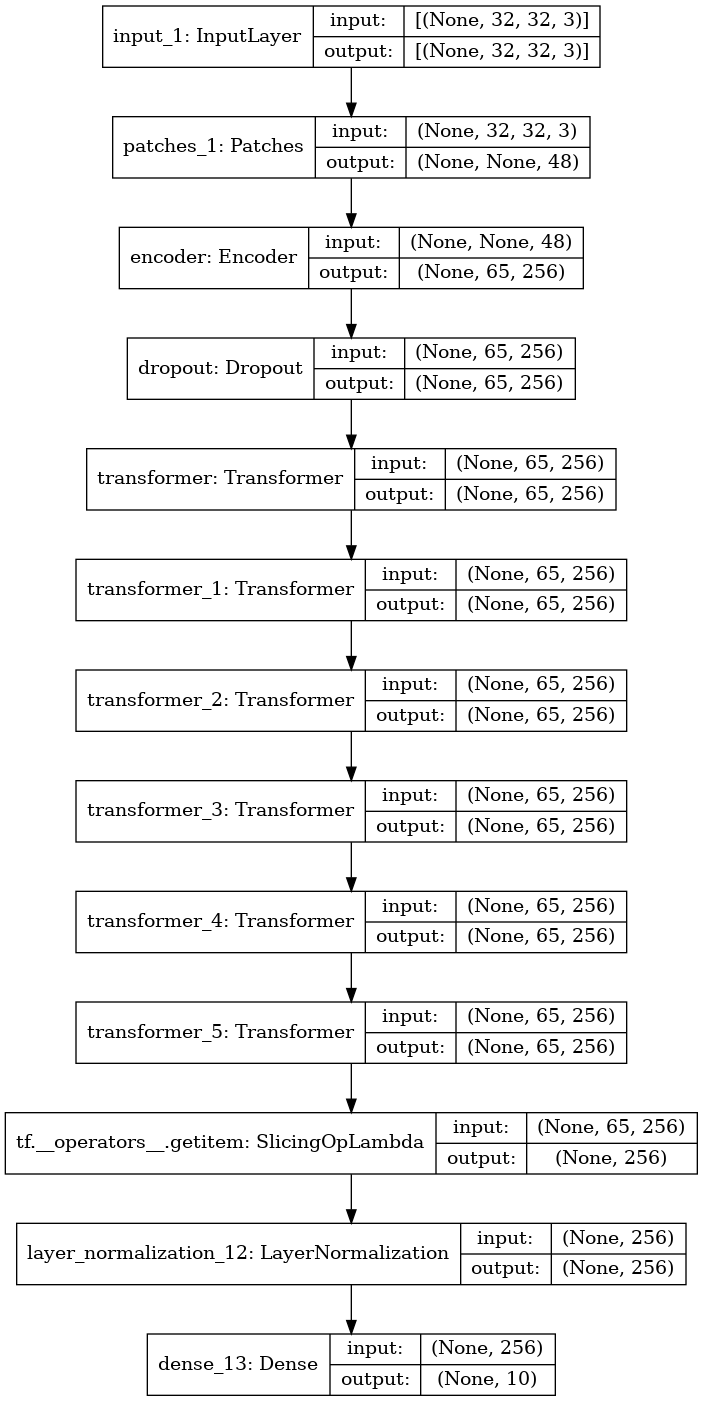

In [12]:
tf.keras.utils.plot_model(vit, to_file='./transformer.png', show_shapes=True, expand_nested=True)

Niestety nie umiem rozwinąć wizualizacji bloków transformer i encoder, ale wydaje mi się, że powinny być dobrze.

In [13]:
def scheduler(epoch, lr):
    if epoch == 100 or epoch == 150:
        return lr * tf.constant(0.1)
    else:
        return lr

cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
vit.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
round(vit.optimizer.lr.numpy(), 5)

1e-05

In [15]:
history = vit.fit(
    x=train_images,
    y=train_labels,
    batch_size=128,
    epochs=160,
    callbacks=[cb],
    validation_data=(test_images, test_labels)
)
round(vit.optimizer.lr.numpy(), 5)

Epoch 1/160


2022-12-02 14:23:03.208208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 109s 260ms/step - loss: 2.3080 - accuracy: 0.1619 - val_loss: 2.0736 - val_accuracy: 0.2101
Epoch 2/160
391/391 [==============================] - 101s 258ms/step - loss: 2.0804 - accuracy: 0.2134 - val_loss: 1.9628 - val_accuracy: 0.2706
Epoch 3/160
391/391 [==============================] - 101s 258ms/step - loss: 1.9682 - accuracy: 0.2552 - val_loss: 1.8661 - val_accuracy: 0.2949
Epoch 4/160
391/391 [==============================] - 101s 258ms/step - loss: 1.8961 - accuracy: 0.2779 - val_loss: 1.8080 - val_accuracy: 0.3244
Epoch 5/160
391/391 [==============================] - 101s 258ms/step - loss: 1.8415 - accuracy: 0.3012 - val_loss: 1.7726 - val_accuracy: 0.3459
Epoch 6/160
391/391 [==============================] - 101s 257ms/step - loss: 1.7885 - accuracy: 0.3231 - val_loss: 1.7151 - val_accuracy: 0.3696
Epoch 7/160
391/391 [==============================] - 101s 258ms/step - loss: 1.7409 - accuracy: 0.3450 - val_loss: 1.6820 - val_

0.0

In [18]:
vit.save_weights("./ViTAdam.h5")

In [19]:
vit.optimizer.lr.numpy()

1e-07

Co ciekawe learning rate na koniec wynosi 1e-07, zaczynaliśmy od 1e-05, więc scheduler zadziałał dobrze (chociaż myślałem, że adam sam dostosowuje learning rate trochę bardziej?).  
Model nauczył się całkiem nieźle, choć niestety dalej nie jakoś wybitnie i na zbiorze testowym osiąga aż/tylko 60% accuracy.

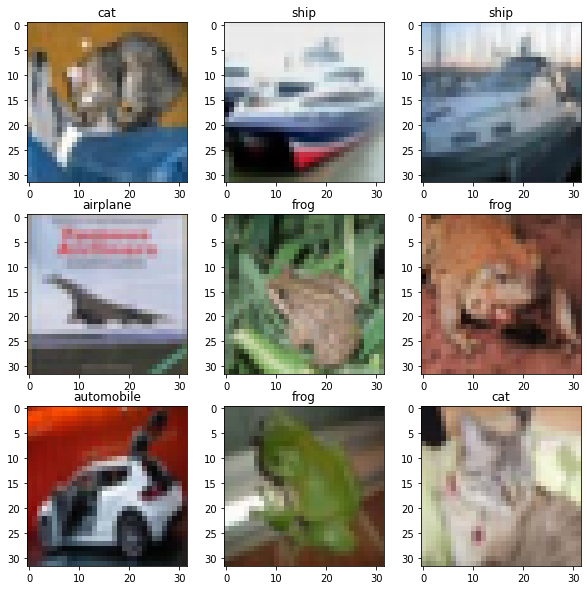

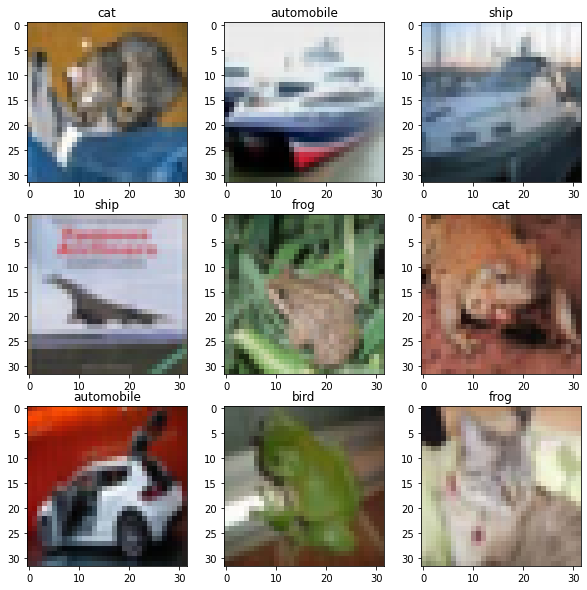

In [33]:
def peak_ds(ds, labels):
    plt.figure(figsize=(10,10))
    for ix, image in enumerate(test_images[:9]):
        plt.subplot(3,3, ix+1)
        plt.imshow(image)
        plt.title(classes[tf.math.argmax(labels[ix])])
    plt.show()

peak_ds(test_images[:9], test_labels[:9])
peak_ds(test_images[:9], vit.predict(test_images[:9]))

Jak zobaczymy co zwraca nasz model to można się nawet troszkę zaśmiać :-) aczkolwiek niektóre wyniki są dobre.  

Próbowałem zrobić Attention Rollout, ale niestety przez to w jaki sposób zdefiniowałem model - przy użyciu functional API, i class'y Layer stworzyłem warstwy transformer i nie umiem z niej wyciągnąc informacji o output'cie multihead attention...  
Nie mam pomysłu jak to łatwo poprawić, a nie mam też czasu uczyć nową sieć.  
Z tego co rozumiem powininenem zaaplikować jakąś funkcję (mean, min) na output'cie multihead attention, tak żeby zebrać razem outputy wszystkich "tokenów" oraz tego trochę nie rozumiem, ale dodajemy macierz identyczności, żeby zasymulować skip connection?. Następnie takie outputy mnożymy między siebie.

Następnie spróbuję wykorzystać AdamW jako optimizer.  
(Tak naprawdę najpierw przetestowałem AdamW i wyszedł gorzej, ale nie mam czasu szukać lepszych parametrów i zostawiłem AdamW na koniec)

In [13]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=0.00001,
    weight_decay=0.00004
)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
vit.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
round(vit.optimizer.lr.numpy(), 5)

1e-05

In [ ]:
history = vit.fit(
    x=train_images,
    y=train_labels,
    batch_size=128,
    epochs=160,
    callbacks=[cb],
    validation_data=(test_images, test_labels)
)
round(vit.optimizer.lr.numpy(), 5)

Epoch 1/160


2022-12-01 18:51:07.180023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 110s 262ms/step - loss: 2.3118 - accuracy: 0.1584 - val_loss: 2.0603 - val_accuracy: 0.2379
Epoch 2/160
391/391 [==============================] - 101s 259ms/step - loss: 2.0671 - accuracy: 0.2216 - val_loss: 1.9248 - val_accuracy: 0.2792
Epoch 3/160
391/391 [==============================] - 101s 260ms/step - loss: 1.9531 - accuracy: 0.2556 - val_loss: 1.8527 - val_accuracy: 0.3038
Epoch 4/160
391/391 [==============================] - 101s 260ms/step - loss: 1.8719 - accuracy: 0.2837 - val_loss: 1.8024 - val_accuracy: 0.3224
Epoch 5/160
391/391 [==============================] - 101s 259ms/step - loss: 1.8198 - accuracy: 0.3033 - val_loss: 1.7838 - val_accuracy: 0.3297
Epoch 6/160
391/391 [==============================] - 101s 259ms/step - loss: 1.7735 - accuracy: 0.3261 - val_loss: 1.7145 - val_accuracy: 0.3595
Epoch 7/160
391/391 [==============================] - 102s 260ms/step - loss: 1.7342 - accuracy: 0.3451 - val_loss: 1.6734 - val_

Niestety obliczenia zawiesiły się przy 148 epokach i zawiesiły notebook, ale widać że być może parametry nie były dobrane najlepiej, ponieważ najlepsze accuracy jest w okolicach 0.55 przy 50 epoce, a później zaczęło spadać. Niestety nie mam czasu próbować szukać innych parametrów.